# kMeans, DBSCAN

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
from clickhouse_driver import Client


user_name = 'user'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

`user_passports`

In [3]:
user_passports_desc = client.execute("""
DESCRIBE TABLE user_passports
""")

user_passports_desc

[('execution_date', 'Date', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', '', ''),
 ('global_id', 'UInt32', '', '', '', '', ''),
 ('created_at', 'DateTime', '', '', '', '', ''),
 ('user_type_id', 'UInt32', '', '', '', '', ''),
 ('user_type_name', 'String', '', '', '', '', ''),
 ('user_type_changed_at', 'DateTime', '', '', '', '', ''),
 ('user_type_cars_id', 'UInt32', '', '', '', '', ''),
 ('user_type_cars_name', 'String', '', '', '', '', ''),
 ('user_type_cars_changed_at', 'DateTime', '', '', '', '', '')]

In [4]:
query = '''
SELECT 
  up.*
FROM 
  user_passports up
'''

In [5]:
result = client.execute(query)

In [6]:
len(result)

2780181

In [7]:
user_passports_df = pd.DataFrame(result, 
                  columns=['execution_date', 'passport_id',
                           'global_id', 'created_at',
                           'user_type_id', 'user_type_name',
                           'user_type_changed_at', 'user_type_cars_id',
                           'user_type_cars_name', 'user_type_cars_changed_at'
                           ])

user_passports_df.head()

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at
0,2023-01-31,143033682,135780497,2022-02-09 14:17:34,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
1,2023-01-31,143084834,148144396,2022-02-17 21:13:52,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
2,2023-01-31,143096954,148160048,2022-02-19 22:15:52,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
3,2023-01-31,143101566,148166116,2022-02-20 18:23:57,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
4,2023-01-31,143115348,148183837,2022-02-22 20:17:22,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16


In [8]:
user_passports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780181 entries, 0 to 2780180
Data columns (total 10 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   execution_date             object        
 1   passport_id                int64         
 2   global_id                  int64         
 3   created_at                 datetime64[ns]
 4   user_type_id               int64         
 5   user_type_name             object        
 6   user_type_changed_at       datetime64[ns]
 7   user_type_cars_id          int64         
 8   user_type_cars_name        object        
 9   user_type_cars_changed_at  datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(3)
memory usage: 212.1+ MB


In [9]:
user_passports_df['execution_date'] = pd.to_datetime(user_passports_df['execution_date'], format='%Y-%m-%d')

In [10]:
user_passports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780181 entries, 0 to 2780180
Data columns (total 10 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   execution_date             datetime64[ns]
 1   passport_id                int64         
 2   global_id                  int64         
 3   created_at                 datetime64[ns]
 4   user_type_id               int64         
 5   user_type_name             object        
 6   user_type_changed_at       datetime64[ns]
 7   user_type_cars_id          int64         
 8   user_type_cars_name        object        
 9   user_type_cars_changed_at  datetime64[ns]
dtypes: datetime64[ns](4), int64(4), object(2)
memory usage: 212.1+ MB


`live_adverts`

In [11]:
live_adverts_desc = client.execute("""
DESCRIBE TABLE live_adverts
""")

live_adverts_desc

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [12]:
query = '''
SELECT 
  la.passport_id,
  COUNT(DISTINCT(la.advert_id)) AS n_ads,
  MIN(la.created_at) AS first_ad,
  AVG(la.price) AS mean_price,
  AVG(CAST(la.year, 'Int64')) AS mean_year
FROM 
  live_adverts la
WHERE 
  la.region = 'Омск'
    AND la.price > 1000
      AND la.year != '0'
GROUP BY
  la.passport_id
'''

In [13]:
result = client.execute(query)

In [14]:
len(result)

35843

In [15]:
live_adverts_df = pd.DataFrame(result, 
                  columns=['passport_id', 'n_ads', 
                           'first_ad', 'mean_price',
                           'mean_year'
                           ])

live_adverts_df.head()

,passport_id,n_ads,first_ad,mean_price,mean_year
0,141450171,2,2022-05-09 14:12:54,1.761905e+05,2006.000000
1,123719602,1,2021-09-15 14:11:38,1.100000e+06,2008.000000
2,144667270,2,2022-12-06 14:41:13,5.000000e+05,2013.000000
3,134267823,16,2022-06-18 15:31:31,6.517922e+05,2004.701299
4,136204801,2,2022-06-14 02:52:06,2.768182e+05,2005.818182


In [16]:
live_adverts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35843 entries, 0 to 35842
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   passport_id  35843 non-null  int64         
 1   n_ads        35843 non-null  int64         
 2   first_ad     35843 non-null  datetime64[ns]
 3   mean_price   35843 non-null  float64       
 4   mean_year    35843 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.4 MB


`user_transactions`

In [17]:
user_transactions_desc = client.execute("""
DESCRIBE TABLE user_transactions
""")

user_transactions_desc

[('payment_date', 'Date', '', '', '', '', ''),
 ('id', 'Int32', '', '', '', '', ''),
 ('type', 'String', '', '', '', '', ''),
 ('sign', 'Int32', '', '', '', '', ''),
 ('amount', 'Int32', '', '', '', '', ''),
 ('tstamp', 'DateTime', '', '', '', '', ''),
 ('advert_id', 'Int32', '', '', '', '', ''),
 ('passport_id', 'Int32', '', '', '', '', ''),
 ('balance_consumption', 'Int32', '', '', '', '', '')]

In [18]:
query = '''
SELECT 
  ut.passport_id,
  COUNT(DISTINCT(ut.type)) AS n_types,
  SUM(ut.sign) AS top_type,
  AVG(ut.balance_consumption) AS mean_transaction
FROM 
  user_transactions ut
GROUP BY
  ut.passport_id
'''

In [19]:
result = client.execute(query)

In [20]:
len(result)

1714980

In [21]:
user_transactions_df = pd.DataFrame(result, 
                  columns=['passport_id', 'n_types', 
                           'top_type', 'mean_transaction'
                           ])

user_transactions_df.head()

,passport_id,n_types,top_type,mean_transaction
0,133483447,2,28,6.833333
1,144659952,1,1,0.000000
2,136275535,1,6,0.000000
3,123683386,4,23,17.600000
4,136981601,2,9,17.272727


Merging data. 

In [22]:
df = pd.merge(user_passports_df, live_adverts_df, on='passport_id', how='inner')

In [23]:
df = pd.merge(df, user_transactions_df, on='passport_id', how='inner')

In [24]:
df

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,n_ads,first_ad,mean_price,mean_year,n_types,top_type,mean_transaction
0,2023-01-31,136749459,141545244,2020-01-02 22:39:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-02-02 13:08:49,5.600000e+05,2002.000000,1,4,0.000000
1,2023-01-31,134387629,137787302,2019-03-05 15:55:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-05-01 11:20:17,1.000000e+05,1993.000000,1,1,0.000000
2,2023-01-31,135129101,139293451,2019-06-04 23:17:10,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-08-03 19:10:09,7.200000e+05,2007.000000,5,149,53.995633
3,2023-01-31,141081287,145779441,2021-04-13 23:02:40,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-05-03 07:42:32,1.191667e+05,2000.666667,1,10,0.000000
4,2023-01-31,131931773,134644283,2018-06-19 17:19:34,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-01-28 04:39:53,1.578049e+05,1996.512195,4,7,68.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30698,2023-01-31,140140656,144655147,2020-11-30 00:13:39,777,profi,2022-11-07 14:14:03,6,cars_seller,2022-11-07 14:14:03,2,2022-11-05 11:07:04,8.611765e+05,2004.764706,12,125,288.696833
30699,2023-01-31,140805655,145457194,2021-03-03 22:37:12,777,profi,2022-07-29 01:31:07,6,cars_seller,2022-07-29 01:31:07,2,2021-12-12 18:44:15,2.203360e+06,2017.000000,9,106,188.234694
30700,2023-01-31,141933123,146738442,2021-08-09 01:22:10,777,profi,2023-01-31 12:44:40,6,cars_seller,2023-01-31 12:44:40,13,2022-07-17 12:34:09,2.402632e+05,2001.736842,1,14,0.000000
30701,2023-01-31,134858035,138873132,2019-04-29 18:51:44,777,profi,2022-11-20 12:46:23,6,cars_seller,2022-11-20 12:46:23,9,2021-07-07 17:42:33,6.618100e+05,2005.840000,10,57,205.609959


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30703 entries, 0 to 30702
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   execution_date             30703 non-null  datetime64[ns]
 1   passport_id                30703 non-null  int64         
 2   global_id                  30703 non-null  int64         
 3   created_at                 30703 non-null  datetime64[ns]
 4   user_type_id               30703 non-null  int64         
 5   user_type_name             30703 non-null  object        
 6   user_type_changed_at       30703 non-null  datetime64[ns]
 7   user_type_cars_id          30703 non-null  int64         
 8   user_type_cars_name        30703 non-null  object        
 9   user_type_cars_changed_at  30703 non-null  datetime64[ns]
 10  n_ads                      30703 non-null  int64         
 11  first_ad                   30703 non-null  datetime64[ns]
 12  mean

In [26]:
del user_passports_df
del live_adverts_df
del user_transactions_df

### Task 2. 

**Find median value of days since ad creation?**

In [27]:
df.head()

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,n_ads,first_ad,mean_price,mean_year,n_types,top_type,mean_transaction
0,2023-01-31,136749459,141545244,2020-01-02 22:39:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-02-02 13:08:49,560000.000000,2002.000000,1,4,0.000000
1,2023-01-31,134387629,137787302,2019-03-05 15:55:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-05-01 11:20:17,100000.000000,1993.000000,1,1,0.000000
2,2023-01-31,135129101,139293451,2019-06-04 23:17:10,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-08-03 19:10:09,720000.000000,2007.000000,5,149,53.995633
3,2023-01-31,141081287,145779441,2021-04-13 23:02:40,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-05-03 07:42:32,119166.666667,2000.666667,1,10,0.000000
4,2023-01-31,131931773,134644283,2018-06-19 17:19:34,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-01-28 04:39:53,157804.878049,1996.512195,4,7,68.571429


In [28]:
df['days_ago'] = (df.execution_date.dt.date - df.created_at.dt.date).dt.days

In [29]:
#df['days_ago'] = df.execution_date - df.created_at
#df['days_ago'] = df['days_ago'].dt.days

In [30]:
#df['days_ago'] = (df.execution_date.dt.date - df.created_at.dt.date) / np.timedelta64(1, 'D')

In [31]:
np.median(df.days_ago)

1098.0

### Task 3.  

**What is the max cars age?** 

In [32]:
df['mean_n_years'] = df.execution_date.dt.year - df.mean_year

In [33]:
df.mean_n_years.max()

73.0

### Task 4. 

**Create a `buyer` feature. Do we have more buyers or sellers in our dataset?**  

In [34]:
df['buyer'] = df.top_type.apply(lambda x: 1 if x < 0 else 0)

In [35]:
df.buyer.value_counts()

0    22844
1     7859
Name: buyer, dtype: int64

### Task 5. 

**Log-transform `price`, choose 6 features, delete outliers and StandardScale them.**

In [36]:
df.sort_values('passport_id', inplace=True)

In [37]:
df = df.reset_index(drop=True)

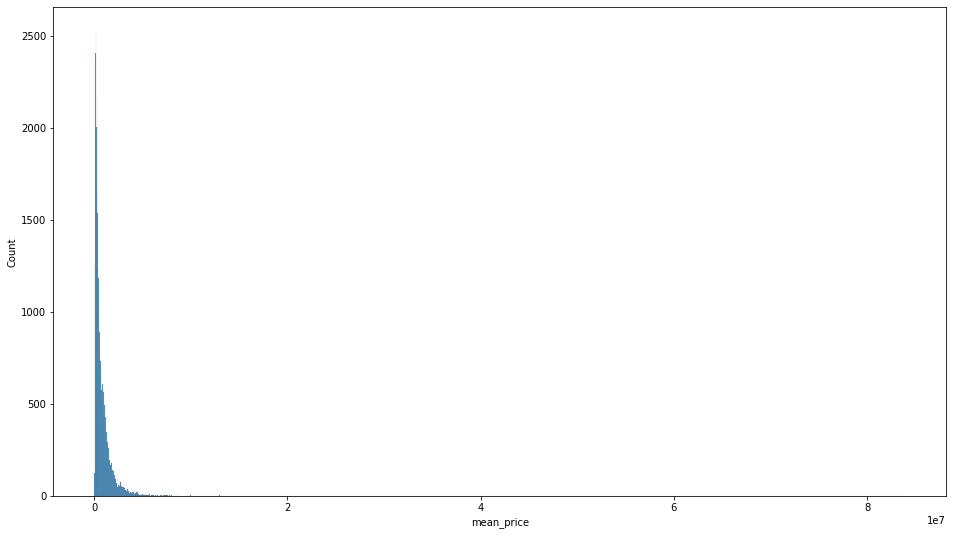

In [38]:
plt.figure(figsize=(16, 9))
sns.histplot(df.mean_price);

In [39]:
df['log_price']= np.log(df['mean_price']) 

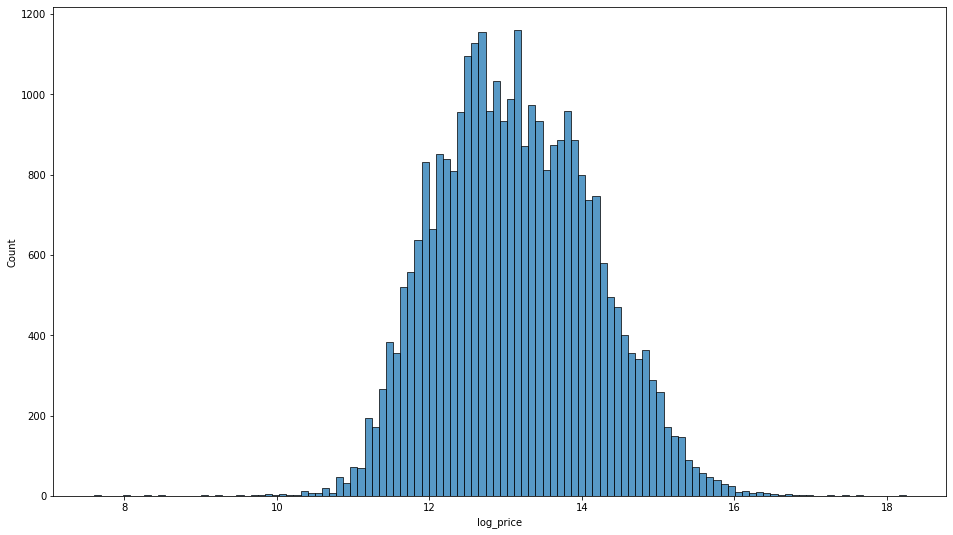

In [40]:
plt.figure(figsize=(16, 9))
sns.histplot(df.log_price);

In [41]:
df.head(3).T

,0,1,2
execution_date,2023-01-31 00:00:00,2023-01-31 00:00:00,2023-01-31 00:00:00
passport_id,123463130,123463864,123464158
global_id,123456861,123457429,123457652
created_at,2009-04-03 19:46:43,2009-04-05 17:11:29,2009-04-06 12:29:57
user_type_id,777,0,0
user_type_name,profi,simple_user,simple_user
user_type_changed_at,2023-01-31 12:44:40,2106-02-07 06:28:16,2106-02-07 06:28:16
user_type_cars_id,0,0,0
user_type_cars_name,cars_simple,cars_simple,cars_simple
user_type_cars_changed_at,2106-02-07 06:28:16,2106-02-07 06:28:16,2106-02-07 06:28:16


In [42]:
data = df[['passport_id', 'n_ads', 'n_types', 'days_ago', 'log_price', 'mean_n_years', 'buyer']]

In [43]:
data.shape

(30703, 7)

In [44]:
data = data[data['n_ads'] < np.quantile(df.n_ads, .99)]

In [45]:
data.shape

(30391, 7)

In [46]:
data = data[data['mean_n_years'] < np.quantile(df.mean_n_years, .99)]

In [47]:
data.shape

(30053, 7)

In [48]:
data = data[data['days_ago'] < np.quantile(df.days_ago, .99)]

In [49]:
data.shape

(29753, 7)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29753 entries, 308 to 30702
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passport_id   29753 non-null  int64  
 1   n_ads         29753 non-null  int64  
 2   n_types       29753 non-null  int64  
 3   days_ago      29753 non-null  int64  
 4   log_price     29753 non-null  float64
 5   mean_n_years  29753 non-null  float64
 6   buyer         29753 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.8 MB


In [51]:
data = data.astype({'passport_id': 'str'})

In [52]:
col_transformer_with_selector = ColumnTransformer(
    transformers=[             
        ('StandardScaler', StandardScaler(), selector(dtype_include='number'))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False   
).set_output(transform='pandas')  

In [53]:
data_scaled = Pipeline(
    [
        ('col_transformer', col_transformer_with_selector)
    ]
)

In [54]:
data_scaled.fit_transform(data)

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,passport_id
308,-0.544056,-0.585612,3.333317,0.619651,-0.960085,-0.585876,123560859
309,-0.544056,-0.585612,3.333317,1.113132,-0.373263,1.706846,123560865
310,-0.204097,1.622578,3.329262,1.120604,0.382332,1.706846,123561915
311,-0.374077,-0.217581,3.329262,1.835067,-0.850545,-0.585876,123561952
313,-0.544056,1.990609,3.327234,1.171393,-1.077450,-0.585876,123562696
...,...,...,...,...,...,...,...
30698,-0.544056,-0.953644,-1.254043,-0.519317,-0.725356,-0.585876,144977962
30699,-0.544056,-0.585612,-1.255057,-0.337495,1.856663,1.706846,144979974
30700,-0.544056,0.518483,-1.255057,0.776405,-0.255898,-0.585876,144983244
30701,-0.544056,-0.217581,-1.255057,-0.337495,-0.490627,-0.585876,144983322


### Task 6. 

**Find the best `eps` parameter for DBSCAN algorithm.**

In [55]:
data_scaled_df = pd.DataFrame(data_scaled.fit_transform(data),
                              columns=['n_ads', 'n_types', 'days_ago',
                                       'log_price', 'mean_n_years', 'buyer', 'passport_id'])

In [56]:
data_scaled_df

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,passport_id
308,-0.544056,-0.585612,3.333317,0.619651,-0.960085,-0.585876,123560859
309,-0.544056,-0.585612,3.333317,1.113132,-0.373263,1.706846,123560865
310,-0.204097,1.622578,3.329262,1.120604,0.382332,1.706846,123561915
311,-0.374077,-0.217581,3.329262,1.835067,-0.850545,-0.585876,123561952
313,-0.544056,1.990609,3.327234,1.171393,-1.077450,-0.585876,123562696
...,...,...,...,...,...,...,...
30698,-0.544056,-0.953644,-1.254043,-0.519317,-0.725356,-0.585876,144977962
30699,-0.544056,-0.585612,-1.255057,-0.337495,1.856663,1.706846,144979974
30700,-0.544056,0.518483,-1.255057,0.776405,-0.255898,-0.585876,144983244
30701,-0.544056,-0.217581,-1.255057,-0.337495,-0.490627,-0.585876,144983322


In [57]:
data_scaled_df = data_scaled_df.drop('passport_id', axis=1)

In [58]:
eps_lst = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
ans_dct = dict()

for e in eps_lst[:7]:
    dbscan = DBSCAN(eps=e, n_jobs=1)
    dbscan.fit(data_scaled_df)
    result = dbscan.labels_
    
    if len(set(result)) >= 3:
        silhouette_ = silhouette_score(data_scaled_df, result)
        ans_dct[e] = silhouette_

In [59]:
ans_dct

{0.1: -0.4452655456650513,
 0.3: -0.5235852178766666,
 0.5: -0.2772561952814787,
 0.7: 0.08888415249661195,
 1: 0.21783758336565262,
 1.5: 0.23774671652733215,
 2: 0.23946201521263877}

### Task 7. 

**Find amount of clusters and number of items in them for the best `eps` parameter obtained on the previous step.**

In [60]:
max_v = -1
max_k = 0

for k, v in ans_dct.items():
    if v > max_v:
        max_v = v
        max_k = k

In [61]:
dbscan = DBSCAN(eps=max_k, n_jobs=1)
dbscan.fit(data_scaled_df)
result = dbscan.labels_

unique, counts = np.unique(result, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   -1     8]
 [    0 22147]
 [    1  7598]]


### Task 8. 

**Find optimal number of clusters using kMeans algorithm.**

In [62]:
data_scaled_df

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer
308,-0.544056,-0.585612,3.333317,0.619651,-0.960085,-0.585876
309,-0.544056,-0.585612,3.333317,1.113132,-0.373263,1.706846
310,-0.204097,1.622578,3.329262,1.120604,0.382332,1.706846
311,-0.374077,-0.217581,3.329262,1.835067,-0.850545,-0.585876
313,-0.544056,1.990609,3.327234,1.171393,-1.077450,-0.585876
...,...,...,...,...,...,...
30698,-0.544056,-0.953644,-1.254043,-0.519317,-0.725356,-0.585876
30699,-0.544056,-0.585612,-1.255057,-0.337495,1.856663,1.706846
30700,-0.544056,0.518483,-1.255057,0.776405,-0.255898,-0.585876
30701,-0.544056,-0.217581,-1.255057,-0.337495,-0.490627,-0.585876


In [63]:
clusters_lst = list(range(3, 11))
ans_dct = dict()

for cluster in clusters_lst:
    kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=1)
    kmeans.fit(data_scaled_df)
    
    silhouette_ = silhouette_score(data_scaled_df, kmeans.labels_)
    ans_dct[cluster] = silhouette_

In [64]:
ans_dct

{3: 0.2533982974016961,
 4: 0.2659711205644356,
 5: 0.272211382600396,
 6: 0.26189671122808983,
 7: 0.22113167852769033,
 8: 0.23016407137655182,
 9: 0.23873260402521662,
 10: 0.23906636388802543}

### Task 9. 

**Use the best `silhoutte_score` parameter for your model. Find the number of users in the smallest cluster.**

In [65]:
max_v = -1
max_k = 0

for k, v in ans_dct.items():
    if v > max_v:
        max_v = v
        max_k = k
        
print(f'{max_k} clusters have the best silhoutte_score: {max_v}')

5 clusters have the best silhoutte_score: 0.272211382600396


In [66]:
kmeans = KMeans(n_clusters=max_k, random_state=42, n_init=1)
kmeans.fit(data_scaled_df)

print(f'Silhoutte_score: {silhouette_score(data_scaled_df, kmeans.labels_)}')

unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

Silhoutte_score: 0.272211382600396
[[    0  6377]
 [    1 11223]
 [    2  2928]
 [    3  1681]
 [    4  7544]]


In [67]:
data['cluster'] = kmeans.labels_
data.head()

,passport_id,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,cluster
308,123560859,1,2,4527,13.753635,9.000000,0,2
309,123560865,1,2,4527,14.248473,14.000000,1,2
310,123561915,3,8,4523,14.255965,20.438017,1,2
311,123561952,2,3,4523,14.972392,9.933333,0,2
313,123562696,1,9,4521,14.306894,8.000000,0,2


In [68]:
data.cluster.value_counts()

1    11223
4     7544
0     6377
2     2928
3     1681
Name: cluster, dtype: int64

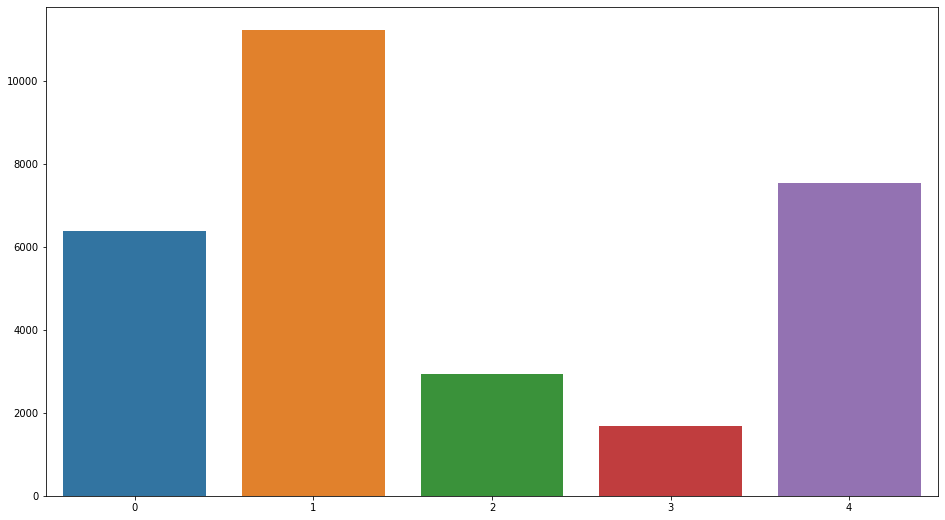

In [69]:
plt.figure(figsize=(16, 9))
sns.barplot(x=data.cluster.value_counts().index, y=data.cluster.value_counts().to_list());

### Task 10. 

**tbc..**